# Polymorphic Uncertainty Quantification for Operational Modal Analysis

### Measurement chain: 

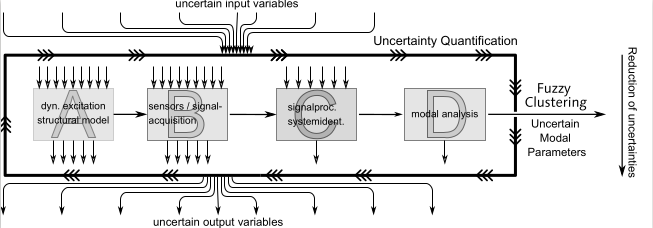


### Scenario / Problem: 

An analyst has been given the task to experimentally identify structural parameters of a (physically existing) guyed mast, with a tuned mass damper. He was provided with numerical estimates of modal parameters with their polymorphic uncertainties. On the given day, when the measurements will be taken, the structural parameters are therefore fixed (unknown to the analyst, but for the forward model, parameters are certain). The mast is assumed time-invariant in the period of the measurement. However, aleatory uncertainties due to the environmental and operational conditions are present in the recorded signals. 

What are the uncertainties of the identified modal paremeters given a single setup measurement using at most xx sensors (xx/2 in each horizontal direction) on the guyed mast example structure? 

### Task:
Based on the given knowledge, the analyst is  tasked to set parameters for measurement and signal acqusition as well as signal processing and system identification. 

### Expected results:
Polymorphically uncertain identified modal parameters of the (certain) structure, e.g. plausibilities of the cumulative probability distribution of the first identified natural frequency. In general the identified modal parameters for a given mode should be very similar, since the structural parameters are not uncertain. In principle errors of numerical vs. identified could be used, but it is preferred to stay "output-only".


### Given knowledge:

    - Modeshapes (Without uncertainties)    
    
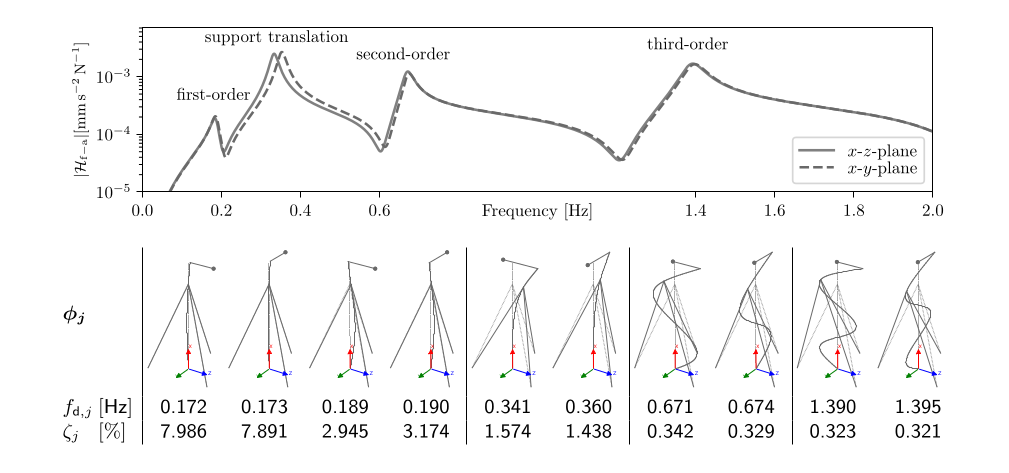

    - Average Natural Frequencies (Plausibility)
    
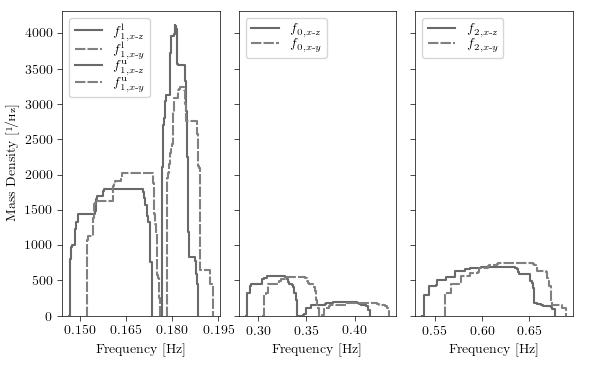
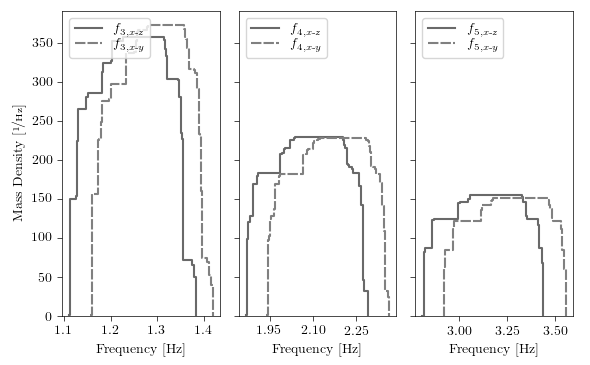

    - Average Damping Ratios (Plausibility)
    
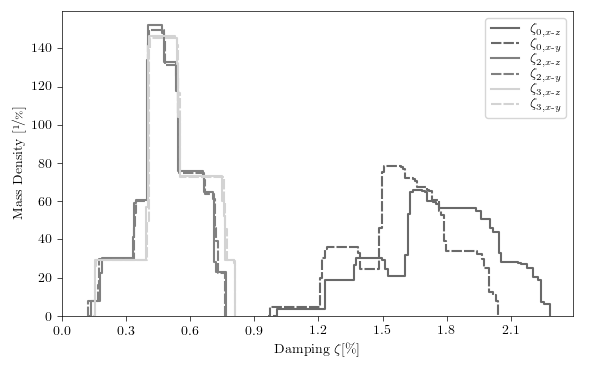
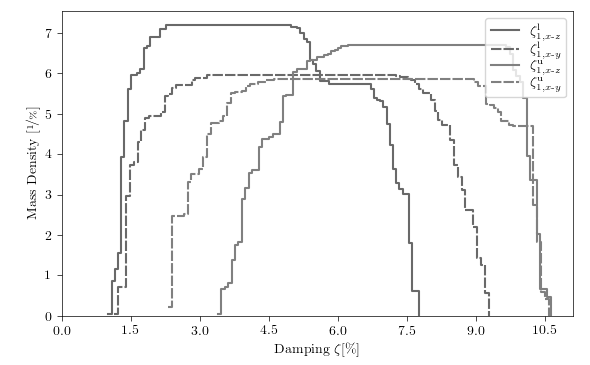

    - Probability Densities of Natural Frequencies, Damping Ratios (Plausibility)
        
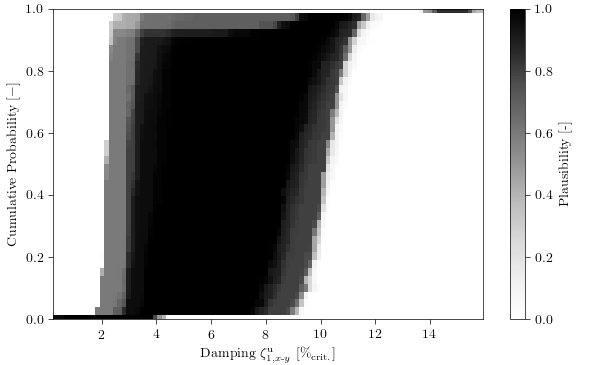
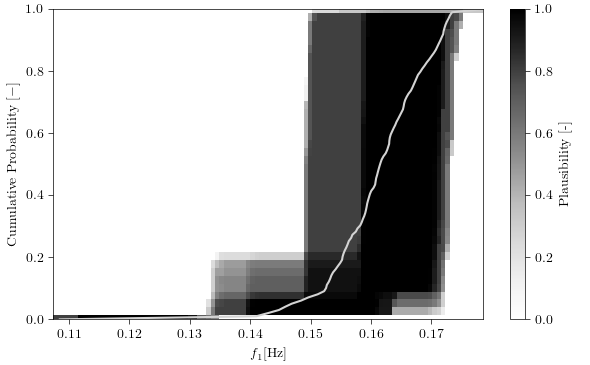

    - Average Accelerance (Plausibility)

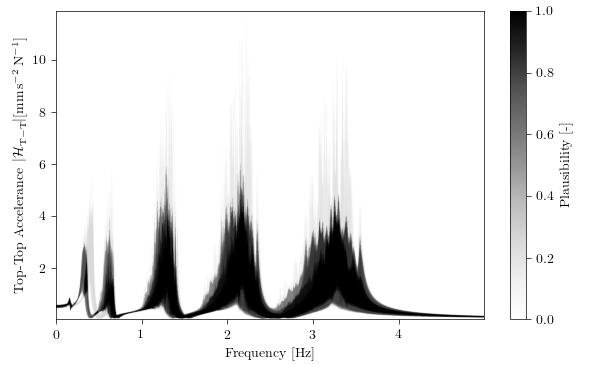

# A: Uncertainty Modeling

# 1. Physical Structure (only aleatory uncertainties in the responses/time series)

The cross-section of the mast is changed from a pipe to a rectangular truss structure to avoid modeling cross-wind vibrations.

The truss structure is based on pictures from Sender Aholming, a guyed truss mast, and parameters are chosen such that mass per meter and second area of moments equal that of the pipe structure, thus previous results can be used.

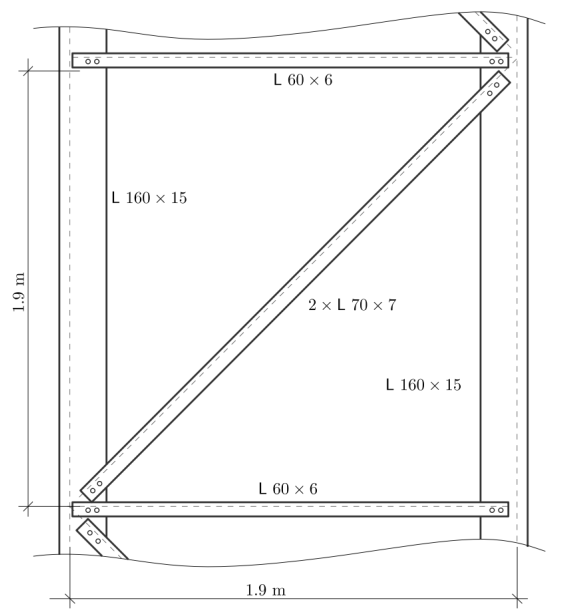

The truss consist of equal leg steel angle profiles. The corners are 160 x 15, the horizontal members are 60 x 6 and the diagonals are two 70 x 7 bolted together on either side of the corner members flange.

The cross-section can be rotated randomly about angle $\alpha$ to contain modes of both directions in each sensor signal and also make sure, the equivalent springs do not act in the principal directions of the cross-section.

Wind excitation is based on EN 1991-1-4 with parameters from [Clobes 2008] and the method given by [Solari 2001], [Shinozuka 1972]. Wind direction is fixed to the models coordinate system, as the cross-section can be rotated w.r.t. the wind direction. Basic wind speed $v_b$ (given fixed in EN 1991-1-4) could be considered as random (Weibull, with parameters as estimated from Geyer monitoring data: $c={0.75:[2.267, 2.3],0.25:[1.96, 2.01]}$, $\lambda={0.75:[5.618, 5.649], 0.25:[5.91,6.0]}$, parameters seem to be independent $\rho= {0.03, 0.3}$).  (Turbulence intensity is proportional to category only and then scales sigma w.r.t. wind speed.)

Wind excitation is computed in the full frequency range that is considered for the model. Otherwise the response mostly vanishes above the wind spectrum, which would mean, these frequency bands would not have to be considered anyway.


Other parameters such as integral lengths $L(z)$, correlation lengths $C_{k,j}$ ($k: {u,v,w}, j: {x,y,z}$), spectral bandwidth $f_{s,w}$ will be considered fixed for now.

#### Given parameters (sample Nr. 566)

$E = 2.1e11$ N m^-2                                          Young's Modulus                                       
$\rho = 7850$ kg m^-3                                        Mass density                                          
$A = 0.03287$ m                                              equivalent cross-section area (average per meter)     
$I_y = 0.01196 $ m^4                                         second moment of area (equivalent of a truss. 80 %)   
$I_z = 0.01304 $ m^4                                         second moment of area (equivalent of a truss. 80 %)   
$\alpha=\frac{\pi}{4}$                                       Angle of cross-section rotation                       
$m_\text{add} = 60$ kg m^-1                                  Additional Mass (Platforms, Cables, Antennas, etc.)   
$N_\text{cbl} = 60 000$ N                                    Pretension of guy cables  (Normal distr.)             
$A_\text{cbl} = 0.00075$ m^2                                 Cross-Sectional Area of cables                          
$d_\text{D} = 200$ Nsm^-1                                    TMD viscosity due to temperature-dependent silicon-oil
$m_\text{D} = 800$ kg                                        TMD mass                                              
$k_{\mathrm{D}} = 1025.48$ Nm^-1                             TMD stiffness                                         
$n_\text{nodes} = 201 + 1 $                                  Number of nodes, excl. internal nodes

#### Problems to be decided:

- Mode shapes should be scaled to unity at the mast tip? no, can be done later
- FRF-based solution will be used (FRF can be precomputed, modal parameters, modeshapes and other parameters are computed once)
    - FRF generation of 360001x402x406 with 46 modes took: 440 GB memory and 840 CPU minutes (parallel numba)
    - Response generation took 70 CPU minutes (parallizable)
    - Excitation generation took: 220 GB memory and 42 CPU minutes
- In the random loop of the first step: generate and save windfield, load FRF, compute and save response

#### Case studies with respect to closely-spaced modes (variables $ I_y, I_z, \alpha$) and global damping (variable $\zeta$)

A) $\zeta = 0.002$ (reference)  
B) $\zeta = 0.0005$ (light damping)  
C) $\zeta = 0.005$ (heavy damping)  
D) $I_y=0.01239$, $I_z=0.01261$, $\alpha=\mathcal{U}(0,\pi)$ (closely-spaced modes)  
E) $\zeta = f(v_b)$ (Amplitude dependent damping)

#### Parameters to be set based on assumptions in subsequent steps:
- Solution time-step: -> $f_s = 100 Hz$
    - for frf-based: corresponding to highest sampling rate max(f_s)
    - for time integration: Should be much smaller than for any desired sampling rate, will be increased in signal acquisition step, corresponding to 10 x max(f_s)
- Solution max length: Will be shortened in signal acqusition step -> based on max measurement duration max(d) -> 1.000 cycles of min(f) -> 1000/0.15 = 6666 s ~ 2 hours
- Solution No. channels: Will be reduced in signal acquisition step -> all (depending on storage requirements and numerical cost)
- Number of modes $n_m$: highest mode in bandwidth corresponding to the solution time-step -> 46 (see plot below structural model generation)

#### Outputs (for verification only, not for uq)#
- (modal parameters are constant)
- polar force amplitude mean and std over time ndarray(202,)
- polar force direction mean and std over time ndarray(202,)
- RMS of d, v, a over time 3 x ndarray(202, 2)

## 2. Sensors / Signal Acquisition

Scenario: Multiple experts have been asked, how they would choose the parameters / what they believe are the ranges of the parameters:

#### Placement of Sensors
- $n_\mathrm{sen} = $ Number of sensors max. 12 channels
- $\operatorname{loc}_\mathrm{sen} = 0.2:[\mathrm{lumped}];0.8:[\mathrm{distributed}]$ Placement of sensors (evenly distributed, every five meters, distance between sensors min. 20 meters; both directions simultaneously!)

#### Type of Sensors
- $q_\mathrm{sen} = 0.8[\mathrm{a}];0.2[\mathrm{v}]$ Measurement quantity (acceleration, velocity)
- $\operatorname{SNR}_\mathrm{sen} = $ Sensor noise variance (pre-sampling, white noise)<br>
**TODO: The datasheets of different sensors should be examined, to obtain reasonable values for these parameters. PCB 393A01, PCB 393B31, Gyralp GMC 40, Lennarts**

#### Signal acqusition system
- Broadband Resolution
    - $q = $ Quantization range. <br>
    **TODO: Usually set on the basis of preliminary measurements. Provide an example signal to given knowledge, and then range x 2 ... 10 and round to a voltage level**
    - $b = [0.05:12, 0.5:16, 0.3:24, 0.05:32]$ Number of quantization bits (**TODO: allow discrete ranges? e.g. 12,16,24,32)**
- Aliasing Filter (FIR: Windowed Sinc)
    - $f_c = $ Filter 3 dB cutoff frequency 2...2.5
    - $w_\mathrm{type}[m]$ Window type  **TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $M = $ Window length
- $f_s = $ Sample rate $f_s = \frac{1}{\Delta t}$
- $N = $ Number of Timesteps / Measurement Duration $T = N \Delta t$
- $\operatorname{SNR}_\mathrm{acq} = $ Acquisition system noise variance (post-sampling, white noise) <br>
  **TODO: Where to get reasonable values? from Datasheets**
- **TODO: model the built-in highpass filter**

#### Outputs
- Total SNR
- Effective quantization bits [Channel average] (Considering range, bits and actual vibration level)
- **TODO: Estimated SNR**

## 3. Signal processing / System identification

#### Signal processing (Consider two analyses in different frequency bands)
- Filter and Decimation (IIR Filter)
    - $M = $ Number of IIR filter coefficients ("order")
    - $f_c =$ Filter 3 dB cutoff frequency
    - $d = $ Decimation rate (every d-th sample)
- $\hat{\Phi}(\omega)$ Spectral estimator (Welch, Blackman-Tukey)
    - Time / Lag Window (If PSDs are involved)  <br>**TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $ 2 (n_\mathrm{lags} - 1) = n_\mathrm{lines}$ Number of time lags ↔ number of frequency lines ($\tau_\mathrm{max} = n_\mathrm{lags} \Delta t$ Correlation length ↔ Frequency Resolution $\Delta f = \frac{f_s}{n_\mathrm{lines}}$)
- use non-reference based OMA ($n_\mathrm{ref}$ Number and $\operatorname{loc}_\mathrm{ref}$ location of reference channels) 

#### Systemidentification
- $n_\mathrm{ord}^\mathrm{max} = $ max model order
- Identification Algorithm (SSI-cov, SSI-data, pLSCF) -> Three case studies, pLSCF might need some work in terms of verification, efficiency, etc.

#### Outputs
- PSD Energy
- **TODO: Cross-validated reconstruction error of the identified system**

## 4. Modal Analysis

#### Parameters 
- $n_\mathrm{ord} = $ Model order -> Clustern!
- $f_\mathrm{max} = $ largest natural frequency of interest

#### Outputs: 
- Store identified modal in the database regardless of assignment to physical modes
- Modal Frequencies
- Modal Damping
- Complex mode shapes at all DOFs (linear interpolation for UQ Processing)
- MPC, (Modal Contributions)
- Selected model order
- Number of modes


# B. Uncertainty Propagation

- Two steps: 
    1. Generate detailed (space and time) structural responses (mostly deterministic, only aleatory uncertainties in the response signals)
    2. Apply Signal Acqusition, Processsing, SysID and Modal onto this data (epistemic and aleatory)
- $N_\mathrm{MCS, ale} = $ Number of samples for aleatory uncertainties (sufficient statistical confidence)
- $N_\mathrm{MCS, epi} = $ Number of samples for epistemic uncertainties (sufficiently small cross-validation error in RBF interpolation)

# C. Uncertainty Processing

**Which outputs do we want to process?**
- Modal Frequencies and Modal damping -> **TODO: Classification / Clustering/ Assignment necessary**
- Mode shapes? -> Would have to be done individually for each DOF, with linear interpolation for unmeasured DOFs

**Which intermediate outputs do we need in the UQ Database? (Others are still stored with the samples)**
- Numerical modal parameters 
- Spectra
- Modal Contributions, MPC, MPD, 
- Signal-to-Noise-Ratio, Effective quantization bits,

**How can we include the existing OMA UQ Methods (aleatory only) in this methodology (in principle it is possible):** 
- Technical details:
    - SSI would take the place of a statistical estimator
    - We would need to **incorporate weights into the routines**
    - The imprecision processing would not be possible, because the modal parameters are not yet available
    - Pre-generation of modal parameters for each imprecision sample not possible due to unknown weights (incompleteness)
    - We have to **combine imprecision and incompleteness processing**
        1. **direct optimization (not feasible):**
            - for each optimizer step: 
                - for each aleatory sample:
                    - compute weights, 
                    - find nearestND impprecision sample (and compute / retrieve correlation function)
                - run modal analysis algorithm
                - select mode of interest, discard other modes -> **useless, too much overhead**
        2. **sample incompleteness along epistemic direction**
            - for each epistemic sample: <br>
                A given aleatory sample may be the bound of any imprecision hypercube. A given imprecision sample thus may be in any of these imprecision hypercubes, in particular after interpolation. So it may have different weights for each imprecision hypercube.
                - for each imprecision hypercube: **(what if the epistemic sample is not in the hypercube?)**
                    - for each aleatory sample:
                        - generate weights
                        - compute / retrieve correlation function
                    - run modal analysis and clustering
                    - store all modes
            - **cluster / classify modes (fuzzy membership?)**
            - select quantity and mode of interest
            - fit an RBF interpolator
            - interval optimization within all imp+inc hypercubes
            - (validate found interval bounds)
            - Procedure:
                1. run DataManager on aleatory samples to generate signals
                2. run DataManager on epistemic samples to identify modes
                    would access all aleatory samples, weights must be provided by freezing inc variable for each epistemic sample and run self.probabilities_imp()
- Fuzzy clustering, etc.

**Do we have to consider anything else regarding further steps (Uncertainty reduction, ANN training, applicability to real measurements, etc.) such that data can be "re-cyled"?**
- Uncertainty reduction and ANN training would include uncertainties of the first step as well
- real measurements would be plugged in instead of generated signals

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
from pathlib import Path


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from examples.UQ_OMA import default_mapping, stage1mapping, stage2mapping, mapping, default_windfield, windfield, plot_response_field, vars_definition

import ray

from uncertainty.polymorphic_uncertainty import PolyUQ
from uncertainty.data_manager import DataManager

import logging
logger= logging.getLogger('uncertainty.data_manager')
logger.setLevel(level=logging.INFO)

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

## Parameters

In [2]:
'''
Continue:


'''

'\nContinue:\n\nprecompute FRF\n\ncheck runtimes:\n    - frf generation 25 min @ 320 GB\n    - windfield generation 8 min @ 240 GB  (Spectral Assembly 3 min , Spectral Decomposition 1:30 min, Fourier assembly 3:30 min)\n    - response computation with memory mapped frf 12 min @ 40 GB\n    - response computation from memory stored frf 4 min @ 480 GB\n    - parallel computation with memmap N * 12 min\n    - serial computation with memmap 12 min + (N - 1) * 4 min\n\ncompute some samples using distributed ray\n\nenlarge sample size\ncompute remaining samples\n\nestimate incompleteness on any output e.g. RMS_a(TMD_y)\n'

In [3]:
vars_ale, vars_epi, arg_vars = vars_definition()
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 1000 # N_mcs = 1e6 = N_mcs_ale * N_mcs_epi
N_mcs_epi = 1 # = 3^6 = 2.56^n_imp ~ 3^n_imp -> cover every corner and midpoints in a full-factorial design (but distributed)
use_dm = True

result_dir = Path('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

In [ ]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=1165763483)
    display(poly_uq.var_supp)
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    
if True:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')

if True:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None


In [5]:
dm_grid = None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')

todo = False    

while todo:    
    todo = dm_grid.evaluate_samples(stage1mapping, arg_vars, 
                         ret_names={'mFm':('node',), 'sFm':('node',), 
                                    'mFd':('node',), 'sFd':('node',), 
                                    'RMSd':('node','dir'),'RMSv':('node','dir'),'RMSa':('node','dir'),}, default_len={'node':203, 'dir':2}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=False,
                         chunks_submit=20, chunks_save=2, scramble_evaluation=False,
                                   remote_kwargs={'num_cpus':1})


INFO:uncertainty.data_manager:0 samples out of 1000 to be done . Submitting at most 0.
0


In [10]:
ray.shutdown()

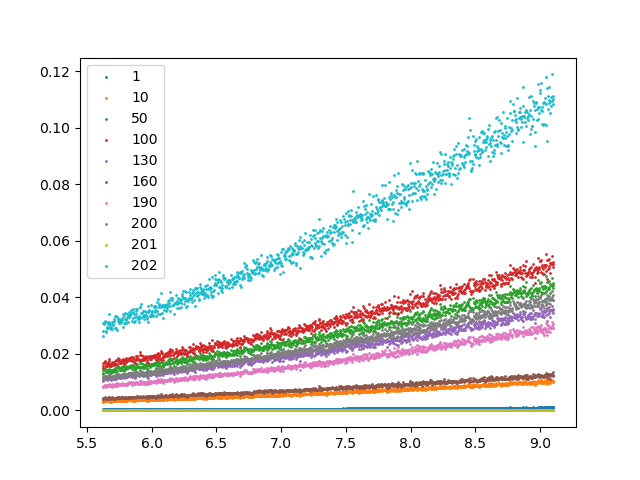

In [15]:
with dm_grid.get_database('out', rw=False) as out_ds, dm_grid.get_database('in', rw=False) as in_ds:
    # display(in_ds)
    # display(out_ds)
    node = 199
    plt.figure()
    v_b = in_ds['v_b']
    for node in [1,10,50,100,130,160,190,200,201,202]:
    
        out = out_ds['RMSd'].loc[{'node':node, 'dir':1}]
        plt.scatter(v_b, out, s=1, label=str(node))
    plt.legend()
    
    

In [ ]:
irun=1
with dm_grid.get_database('in') as db:
    for jid in db.ids:
        jid = jid.item()
        print(jid)
        v_b = db['v_b'].sel(ids=jid).data


        zeta = 0.002 # normal damping
        # zeta = 0.0005 # light damping
        # zeta = 0.005 # heavy damping
        Iy = 0.01196
        Iz = 0.01304
        alpha = 45

        fs_m = 70
        duration = 2**19/fs_m
        
        
        
        skip_existing = True


        success = mapping(zeta=zeta, Iy=Iy, Iz=Iz, alpha=alpha, 
                    v_b=v_b, fs_m=fs_m, duration=duration, 
                    jid=jid, result_dir=result_dir / 'samples', working_dir='/dev/shm/womo1998/', skip_existing=skip_existing)
        print(success)

## Structural Model generation

In [6]:
from model.mechanical import Mechanical, MechanicalDummy

if os.path.split(result_dir)[-1] != 'samples':
    result_dir=result_dir / 'samples'

jid = 'd3f294e6_e3f6077f'

zeta = 0.002 # normal damping
# zeta = 0.0005 # light damping
# zeta = 0.005 # heavy damping
Iy = 0.01196
Iz = 0.01304
alpha = 45

fs_m = 70
duration = 2**19/fs_m

v_b = 25.0
skip_existing = True

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / id_ale
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)

    this_result_dir = this_result_dir / id_epi
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)
else:
    this_result_dir = result_dir / jid
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)


seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')
        
# assemble structural parameters
struct_parms = {
        'L'         : 200,

        'E'         : 2.1e11,
        'A'         : 0.03287,

        'x_knl'     : 160,

        'm_tmd'     : 800,
        'ky_tmd'    : 1025.48,
        'kz_tmd'    : 1025.48,
        'dy_tmd'    : 200,
        'dz_tmd'    : 200,
        'x_tmd'     : 200,
        }

# Cross-section
Iyz = 0
# rotate cross section about angle alpha
alpha = alpha * 2 * np.pi / 360
struct_parms['Iy'] = 0.5 * (Iy + Iz) + 0.5 * (Iy - Iz) * np.cos(2 * alpha) + Iyz * np.sin(2 * alpha)
struct_parms['Iz'] = 0.5 * (Iy + Iz) - 0.5 * (Iy - Iz) * np.cos(2 * alpha) - Iyz * np.sin(2 * alpha)
struct_parms['Iyz'] = -0.5 * (Iy - Iz) * np.sin(2 * alpha) + Iyz * np.cos(2 * alpha)

# equivalent spring stiffness of guy cables
A_wire = 0.00075
rho = 7850
N_wire = 60000
Aeq = A_wire/(1 + (A_wire * rho * 9.819 * 70 / N_wire)**2 * struct_parms['E'] * A_wire / 12 / N_wire)
keq = (struct_parms['E'] * Aeq * (70**2 / (70**2 + 160**2)) + N_wire) / np.sqrt(70**2 + 160**2)
struct_parms['kz_nl'] = 1.7 * keq
struct_parms['ky_nl'] = 2 * keq

# additional mass into mass density
add_mass = 60
struct_parms['rho'] = rho + add_mass / struct_parms['A']

# model parameters
num_nodes = 201
num_modes = 38 # ensure max(f) is below nyquist frequency to avoid wrap-around in the frf

# load or build structural model
mech = None
if skip_existing and os.path.exists(result_dir / f'mechanical.npz'):
    try:
        mech = MechanicalDummy.load(fpath=result_dir / f'mechanical.npz')
        assert mech.struct_parms['Iy'] == struct_parms['Iy']
        assert mech.struct_parms['Iz'] == struct_parms['Iz']
        assert mech.struct_parms['Iyz'] == struct_parms['Iyz']
        assert mech.damping == zeta
        assert mech.omegas is not None
        assert mech.frf is not None
    except Exception as e:
        mech = None
        raise e

if mech is None:
    global ansys
    if 'ansys' not in globals():
        ansys = Mechanical.start_ansys(working_dir=working_dir, jid=jid)
    mech = Mechanical(ansys=ansys, jobname=jid, wdir=working_dir)
    mech.build_conti(struct_parms, 
                     Ldiv=num_nodes, damping=zeta, 
                     num_modes=num_modes)
    
f,d,phi = mech.modal()
plt.figure()
plt.axhline(zeta, color='grey')
plt.axvline(fs_m/2, color='grey')
plt.scatter(f,d,  marker='x', color='k')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Natural Frequency [Hz]')
plt.ylabel('Modal damping ratio [%]')
# plt.yscale('log')

INFO:model.mechanical:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/mechanical.npz


AttributeError: 'MechanicalDummy' object has no attribute 'modal'

## Windfield generation

In [ ]:
from model.turbulent_wind import plot_windfield
from examples.UQ_OMA import windfield

# Spatial domain grid
x_grid = mech.nodes_coordinates[0:-2,1]
if os.path.exists(this_result_dir / 'excitation.npz') and skip_existing:
    arr = np.load(this_result_dir / 'excitation.npz')
    Fu_time = arr['Fu_time']
    Fv_time = arr['Fv_time']
else:
    x_grid = mech.nodes_coordinates[0:-2,1]
    
    category = 3
    C_uz = 10
    C_vz = 7
    b = 1.9
    cscd = 1.0
    cf = 2.86519
    
    Fu_time, Fv_time = windfield(x_grid, 
                                 category, v_b, 
                                 fs_m, duration, 
                                 C_uz, C_vz, 
                                 b, cscd, cf,
                                 seed)
    np.savez(this_result_dir / 'excitation.npz',
             Fu_time=Fu_time, Fv_time=Fv_time,)

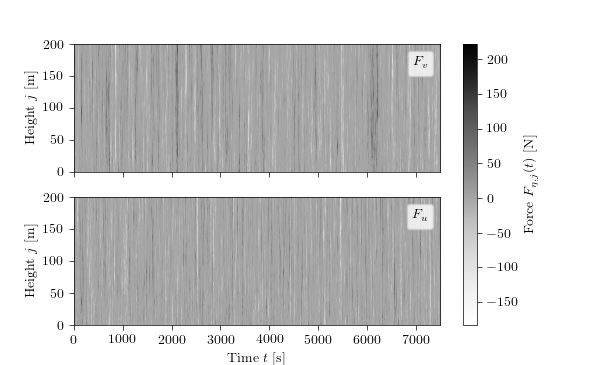

In [42]:
plt.close("all")

matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    
    Fmin = min([Fu_time.min(), Fv_time.min()])
    Fmax = max([Fu_time.max(), Fv_time.max()])
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
    (ax1, ax2) = axes
    im1 = ax1.imshow(Fu_time.T, origin='lower', aspect='auto', extent=(0, duration, 0, struct_parms['L']), 
                     vmin=Fmin, vmax=Fmax, cmap='Greys')
    im2 = ax2.imshow(Fv_time.T, origin='lower', aspect='auto', extent=(0, duration, 0, struct_parms['L']), 
                     vmin=Fmin, vmax=Fmax, cmap='Greys')
    ax2.set_xlabel('Time $t$ [\si{\second}]')
    ax1.set_ylabel('Height $j$ [\si{\metre}]')
    ax2.set_ylabel('Height $j$ [\si{\metre}]')
    # cbar = plt.colorbar()
    # cbar.set_label('Force $F_{u,j}(t)$ [\si{\\newton}]')
    fig.colorbar(im2, ax=axes).set_label('Force $F_{\eta,j}(t)$ [\si{\\newton}]')
    axes[1].legend(title='$F_u$')
    axes[0].legend(title='$F_v$')
    plt.show()

## Transient Solution

In [13]:
%%time
if os.path.exists(this_result_dir / 'response.npz') and skip_existing:
    arr = np.load(this_result_dir / 'response.npz')
    t_vals = arr['t_vals']
    d_freq_time = arr['d_freq_time']
    v_freq_time = arr['v_freq_time']
    a_freq_time = arr['a_freq_time']
else:
    t_vals, response = mech.transient_ifrf(Fu_time, Fv_time,
                                           mech.nodes_coordinates[0:-2,0],
                                           inp_dt = 1 / fs_m)

    [d_freq_time, v_freq_time, a_freq_time] = response       
    # FRF was not pre-computed: save, clear and exit
    if isinstance(mech, Mechanical):
        print('save')
        mech.save(os.path.join(result_dir, 'mechanical.npz'))
        ansys.finish()
        ansys.cwd('/dev/shm/womo1998/')
        ansys.clear()
    
    np.savez(this_result_dir / 'response.npz', 
             t_vals=t_vals, 
             d_freq_time=d_freq_time, 
             v_freq_time=v_freq_time, 
             a_freq_time=a_freq_time)
    print(this_result_dir / 'response.npz')

# zeros = np.zeros((N_m, 1))
# t, [d_time, v_time, a_time] = mech.transient(fy=np.hstack((Fu_time, zeros, zeros)), 
#                                              fz=np.hstack((Fv_time, zeros, zeros)), 
#                                              deltat=1 / fs_m, timesteps=N_m)
# # remove DOF x
# d_time = d_time[:,:,1:]
# v_time = v_time[:,:,1:]
# a_time = a_time[:,:,1:]

CPU times: user 5.85 s, sys: 2.69 s, total: 8.54 s
Wall time: 10.9 s


(<Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>)

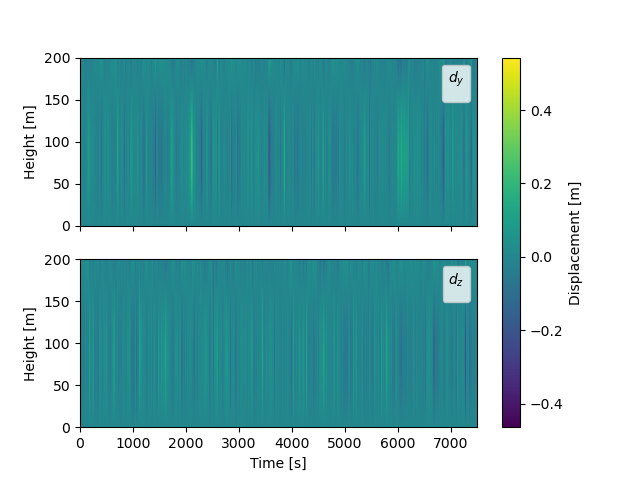

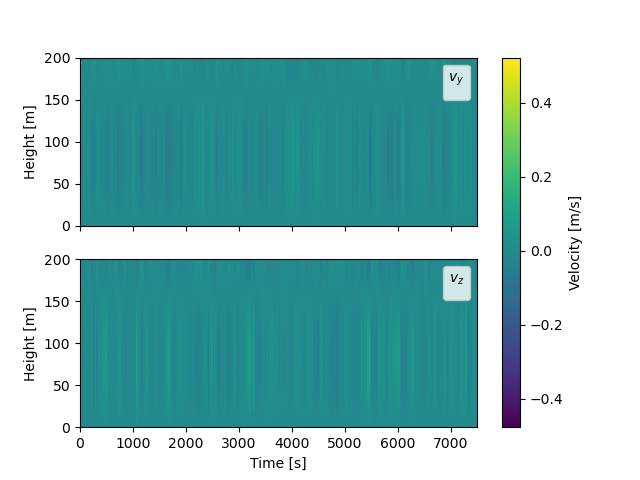

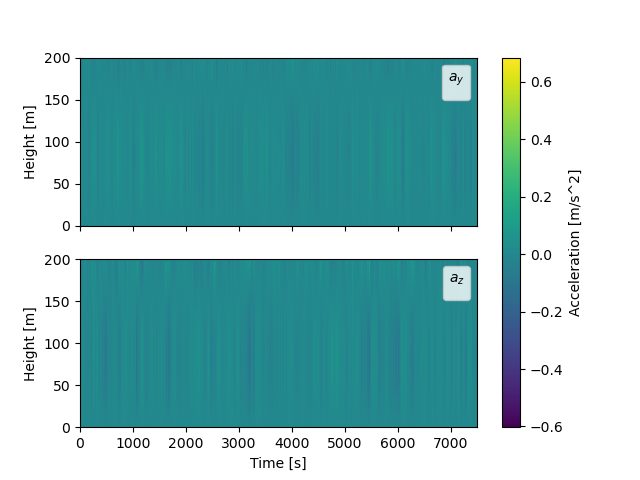

In [14]:
plot_response_field(d_freq_time, v_freq_time, a_freq_time, duration, height=200)

In [19]:
Fu_time.shape

(524288, 201)

Text(0, 0.5, 'Height [m]')

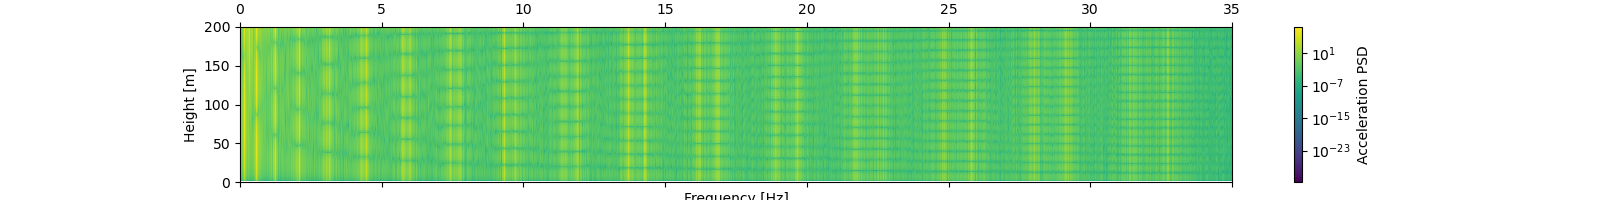

In [15]:
a_time_spec = np.fft.rfft(a_freq_time, axis=0)**2
a_time_spec_polar_mag = np.abs(a_time_spec[:,:num_nodes,0].T) + np.abs(a_time_spec[:,:num_nodes,1].T)
plt.matshow(a_time_spec_polar_mag, origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]), norm='log')
plt.colorbar().set_label('Acceleration PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Height [m]')

In [ ]:
fig, ani = animate_response(mech.nodes_coordinates, d_freq_time=d_freq_time, Fu_time=Fu_time, Fv_time=Fv_time, N_frames=250)

In [ ]:
ani.pause()
ani._stop()
plt.close('all')
del ani

In [ ]:
import glob
from model.mechanical import Mechanical, MechanicalDummy



result_dir = Path('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples')
working_dir = Path('/dev/shm/womo1998/')


flist = glob.glob('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/*/*')
todolist = []
for file in flist:
    if not os.path.exists(file+'/response.npz'):
        todolist.append(file)

print(todolist, len(todolist))
        



mech = MechanicalDummy.load(fpath=result_dir / f'mechanical.npz')
frf = np.empty_like(mech.frf)
frf[:] = mech.frf
mech.frf = frf




for i in range(len(todolist)):
    path = todolist[i]
    path, eid = os.path.split(path)
    path, aid = os.path.split(path)
    if eid != 'e3f6077f': 
        continue
    jid = aid + '_' + eid
    
    try:
        stage2mapping(mech, jid, result_dir, True)
    except Exception as e:
        print(e)